# Bayseian Poisson Regression

In [1]:
using Turing, DataFrames, StatsPlots, Distributions, Distributed, MCMCChains, Plots, Random
Random.seed!(12)

TaskLocalRNG()

In [5]:
# Generation of data
theta_noalcohol_meds= 1   # no alcohol, took med
theta_alcohol_meds= 3     # alcohol, took med
theta_noalcohol_nomeds= 6 # no alcohol, no med
theta_alcohol_nomeds=  36 # alcohol, took med

# Number of samples from each case above
q= 100

# Generate data from different Poisson distros
noalcohol_meds= Distributions.Poisson(theta_noalcohol_meds)
alcohol_meds= Distributions.Poisson(theta_alcohol_meds)
noalcohol_nomeds= Distributions.Poisson(theta_noalcohol_nomeds)
alcohol_nomeds= Distributions.Poisson(theta_alcohol_nomeds)

nsneeze_dat= vcat(rand(noalcohol_meds, q), rand(alcohol_meds, q), rand(noalcohol_nomeds, q), rand(alcohol_nomeds, q))
alcohol_dat= vcat(zeros(q), ones(q), zeros(q), ones(q))
meds_dat= vcat(zeros(q), zeros(q), ones(q), ones(q))

df= DataFrames.DataFrame(nsneeze= nsneeze_dat, alcohol_taken= alcohol_dat,
                         nomeds_taken= meds_dat, product_alcohol_me= meds_dat .* alcohol_dat)
df[Turing.sample(1:nrow(df), 5, replace=false), :]

5×4 DataFrame
 Row │ nsneeze  alcohol_taken  nomeds_taken  product_alcohol_me 
     │ Int64    Float64        Float64       Float64            
─────┼──────────────────────────────────────────────────────────
   1 │       1            0.0           0.0                 0.0
   2 │       6            0.0           1.0                 0.0
   3 │      31            1.0           1.0                 1.0
   4 │      32            1.0           1.0                 1.0
   5 │      46            1.0           1.0                 1.0

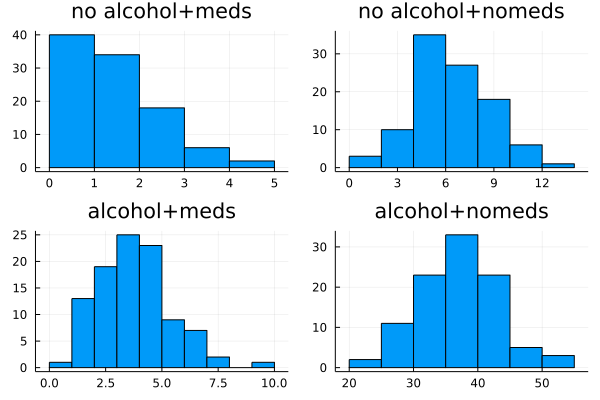

In [7]:
# Viz of data
p1= Plots.histogram(df[(df[:, :alcohol_taken] .== 0) .& (df[:, :nomeds_taken] .== 0), 1], title= "no alcohol+meds")
p2= Plots.histogram(df[(df[:, :alcohol_taken] .== 0) .& (df[:, :nomeds_taken] .== 1), 1], title= "no alcohol+nomeds")
p3= Plots.histogram(df[(df[:, :alcohol_taken] .== 1) .& (df[:, :nomeds_taken] .== 0), 1], title= "alcohol+meds")
p4= Plots.histogram(df[(df[:, :alcohol_taken] .== 1) .& (df[:, :nomeds_taken] .== 1), 1], title= "alcohol+nomeds")

Plots.plot(p1, p2, p3, p4, layout= (2,2), legend= false)

In [13]:
# Convert dataframe to matrix for the poisson model
data= Matrix(df[:, [:alcohol_taken, :nomeds_taken, :product_alcohol_me]])
data_labels= df[:, :nsneeze]


400-element Vector{Int64}:
  1
  2
  0
  2
  0
  2
  0
  0
  0
  1
  0
  1
  3
  ⋮
 38
 29
 41
 36
 46
 35
 35
 24
 33
 37
 32
 20

In [16]:
# Standarize data for Turing
data= (data .- mean(data)) ./ std(data, dims=1)

400×3 Matrix{Float64}:
 -0.815124  -0.815124  -0.943879
 -0.815124  -0.815124  -0.943879
 -0.815124  -0.815124  -0.943879
 -0.815124  -0.815124  -0.943879
 -0.815124  -0.815124  -0.943879
 -0.815124  -0.815124  -0.943879
 -0.815124  -0.815124  -0.943879
 -0.815124  -0.815124  -0.943879
 -0.815124  -0.815124  -0.943879
 -0.815124  -0.815124  -0.943879
 -0.815124  -0.815124  -0.943879
 -0.815124  -0.815124  -0.943879
 -0.815124  -0.815124  -0.943879
  ⋮                    
  1.18237    1.18237    1.36263
  1.18237    1.18237    1.36263
  1.18237    1.18237    1.36263
  1.18237    1.18237    1.36263
  1.18237    1.18237    1.36263
  1.18237    1.18237    1.36263
  1.18237    1.18237    1.36263
  1.18237    1.18237    1.36263
  1.18237    1.18237    1.36263
  1.18237    1.18237    1.36263
  1.18237    1.18237    1.36263
  1.18237    1.18237    1.36263

In [17]:
# Declaring the Poisson Model

@model poisson_reg(x, y, n, σ)= begin
    b0~ Turing.Normal(0, σ)
    b1~ Turing.Normal(0, σ)
    b2~ Turing.Normal(0, σ)
    b3~ Turing.Normal(0, σ)
    
    for i in 1:n
        theta= b0 + b1*x[i,1] + b2*x[i,2] + b3*x[i,3]
        y[i]~ Turing.Poisson(exp(theta))
    end
end

poisson_reg (generic function with 2 methods)

In [24]:
# Retrieve number of obs
n, _ = size(data)

# Sampling with NUTS
num_chains=4
m= poisson_reg(data, data_labels, n, 10)
chain= Turing.sample(m, NUTS(200, 0.5), MCMCThreads(), 2500, num_chains, discard_adapt=false)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/doppelganger/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/doppelganger/.julia/packages/Turing/QRn5N/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/doppelganger/.julia/packages/Turing/QRn5N/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/doppelganger/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /home/doppelganger/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/doppelganger/.julia/p

Chains MCMC chain (2500×16×4 Array{Float64, 3}):

Iterations        = 1:1:2500
Number of chains  = 4
Samples per chain = 2500
Wall duration     = 31.35 seconds
Compute duration  = 27.76 seconds
parameters        = b0, b1, b2, b3
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          b0    1.4361    0.1042     0.0010    0.0044   522.8675    1.0091     ⋯
          b1    0.6168    0.0943     0.0009    0.0044   444.1958    1.0111     ⋯
          b2    0.9111    0.0686     0.0007    0.0025   812.7196    1.0079     ⋯
          b3    0.2596    0.0791     0.0008    0.0031   703.9947    1.0070     ⋯
                                                            

In [25]:
# Vizualizing diagnostics
Turing.gelmandiag(chain)

Gelman, Rubin, and Brooks diagnostic
  parameters      psrf    psrfci 
      Symbol   Float64   Float64 

          b0    1.1026    1.1231
          b1    1.0725    1.0972
          b2    1.0179    1.0252
          b3    1.0297    1.0401


In [34]:
# Recover the coefficients in standar form
c1= chain[:,:,1]

# Get the exp of the mean of coeff
b0_exp= exp(mean(c1[:b0]))
b1_exp= exp(mean(c1[:b1]))
b2_exp= exp(mean(c1[:b2]))
b3_exp= exp(mean(c1[:b3]))

println("b0: ", round(b0_exp, digits=2), "\n", 
      "b1: ", round(b1_exp, digits=2), "\n", 
      "b2: ", round(b2_exp, digits=2), "\n", 
      "b3: ", round(b3_exp, digits=2), "\n")

b0: 4.15
b1: 1.88
b2: 2.5
b3: 1.29



In [47]:
psize= Vector{Int}(undef,2)
psize= [800,800]

2-element Vector{Int64}:
 800
 800

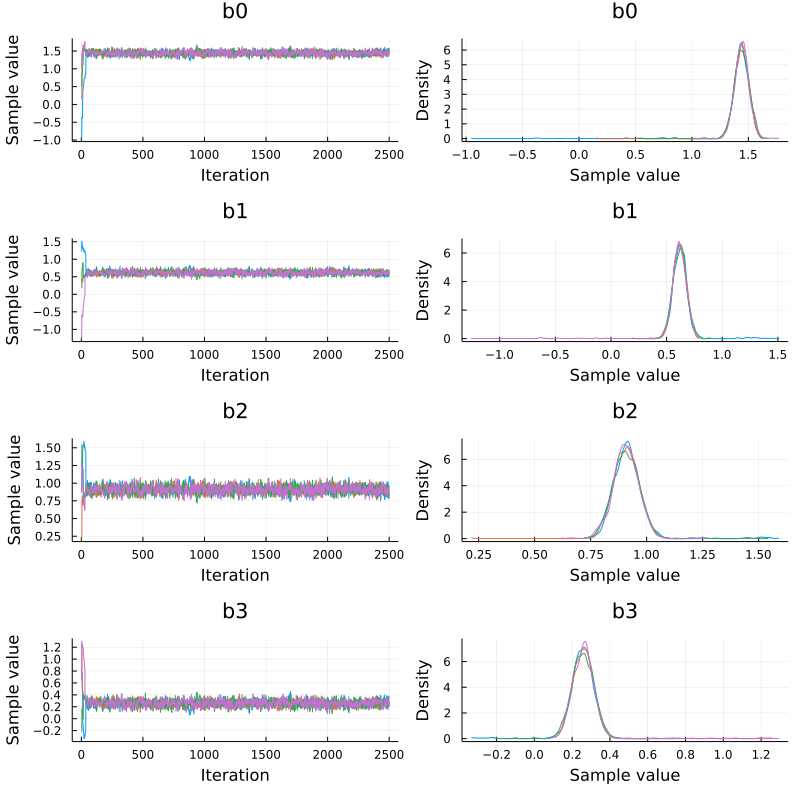

In [48]:
Plots.plot(chain, size= psize)

In [54]:
#
describe(chain)

# Remove the first 300 values in the chains
chain_new= chain[301:2500,:,:]
describe(chain_new)

2-element Vector{ChainDataFrame}:
 Summary Statistics (4 x 8)
 Quantiles (4 x 6)

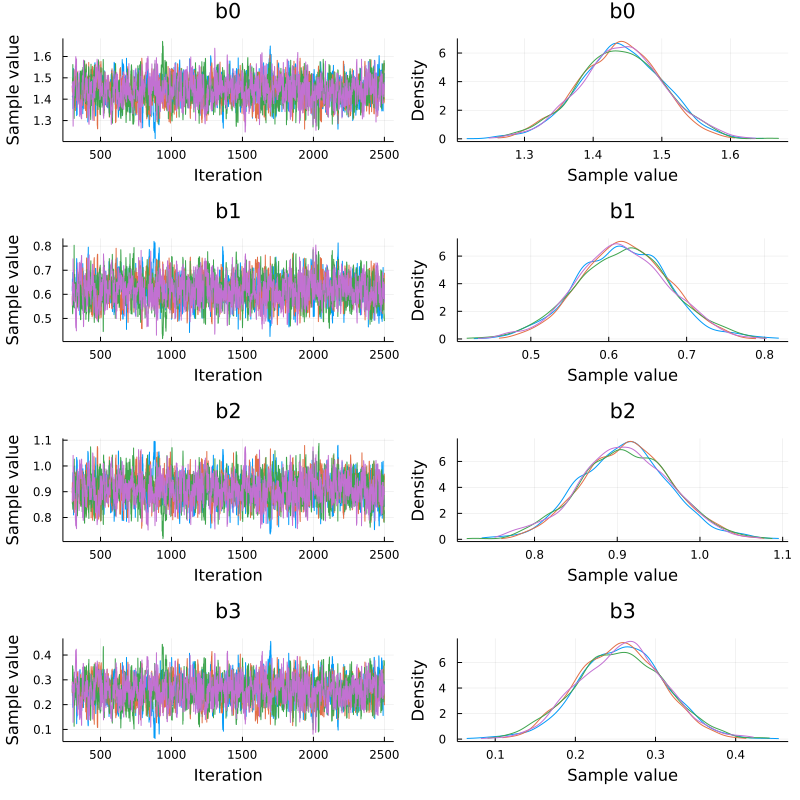

In [70]:
plot(chain_new, size= psize)

In [84]:
c1=chain[:,:,1]


Chains MCMC chain (2500×16×1 Array{Float64, 3}):

Iterations        = 1:1:2500
Number of chains  = 1
Samples per chain = 2500
Wall duration     = 31.35 seconds
Compute duration  = 27.76 seconds
parameters        = b0, b1, b2, b3
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          b0    1.4231    0.1620     0.0032    0.0161    81.5898    1.0176     ⋯
          b1    0.6289    0.0981     0.0020    0.0097    73.2353    1.0211     ⋯
          b2    0.9180    0.0842     0.0017    0.0075    86.9227    1.0231     ⋯
          b3    0.2534    0.0786     0.0016    0.0043   233.8806    1.0103     ⋯
                                                            

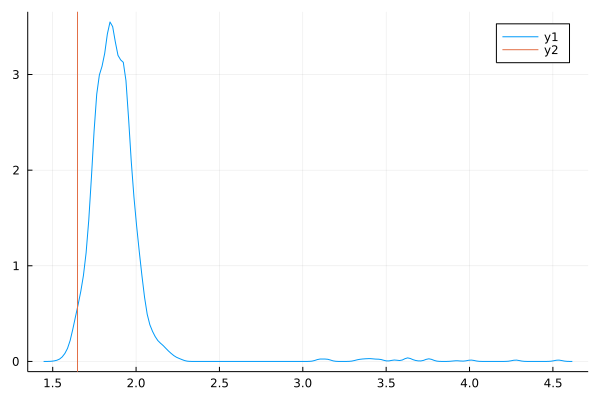

In [117]:
Plots.density(exp.(c1[:b1]))
mean_sneeze= mean(meds_dat)
vline!([exp(mean_sneeze)])